In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable

import os
import math
import librosa
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sps

from tqdm import tqdm
from text import text_to_sequence
from audio import melspectrogram
from scipy.io.wavfile import read

In [2]:
class Config:
    # default
    base_path = './data'
    data_path = "./data/wavs/"
    preprocess_base_path = base_path + '/preprocessed'

    # preprocess
    max_wav_value = 32768
    sampling_rate=22050
    filter_length=1024
    hop_length=256
    win_length=1024
    n_mel_channels=80
    mel_fmin=0.0
    mel_fmax=8000.0

    preemphasize=True
    preemphasis=0.97
    ref_level_db=20
    min_level_db=-100
    signal_normalization=True
    allow_clipping_in_normalization=True
    symmetric_mels=True
    use_lws=False
    frame_shift_ms=None
    max_abs_value=4.

    # metadata
    data_path = base_path + '/wavs'
    metadata_path = base_path + '/metadata.csv'

    # train
    batch_size = 16

    # model
    num_phonemes = 70
    num_mels = 80
    embedding_dim = 512
    d_model = 256
    num_heads = 8
    num_encoder_layers = 6
    num_decoder_layers = 6

    # github params
    n_symbols = 71
    n_speakers = 1
    d_model = 512

config = Config()

In [3]:
def visualize_spectrogram(mel_pred, mel_out):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))


    im1 = ax1.imshow(mel_pred, aspect="auto", origin="lower", interpolation='none')
    plt.colorbar(im1, ax=ax1)
    ax1.set_title("Prediction")
    ax1.set_xlabel("Frames")
    ax1.set_ylabel("Channels")

    im2 = ax2.imshow(mel_out, aspect="auto", origin="lower", interpolation='none')
    plt.colorbar(im2, ax=ax2)
    ax2.set_title("Target")
    ax2.set_xlabel("Frames")
    ax2.set_ylabel("Channels")

    plt.tight_layout()
    plt.show()

In [4]:
def load_filepaths_and_text(metadata_path):
    # audiopaths_and_text는 metadata.csv 파일을 가리킴
    audiopaths_and_text = []
    with open(metadata_path, "r") as metadata_f:
        lines = metadata_f.readlines()
        for line in lines:
            audiopath, _, text = line.split('|')
            audiopaths_and_text.append([audiopath, text])

    return audiopaths_and_text

def load_wav_to_torch(audio_path, target_sampling_rate=22050):
    sampling_rate, data = read(audio_path)
    number_of_samples = round(len(data) * float(target_sampling_rate) / sampling_rate)
    sampling_rate = target_sampling_rate
    data = sps.resample(data, number_of_samples)
    return torch.FloatTensor(data.astype(np.float32)), sampling_rate


class TextMelLoader(torch.utils.data.Dataset):
    def __init__(self, audiopaths_and_text, config):
        self.audiopaths_and_text = load_filepaths_and_text(audiopaths_and_text)
        self.config = config
        self.data_path = config.data_path
        self.max_wav_value = config.max_wav_value
        pass

    def get_text(self, text):
        text = torch.IntTensor(text_to_sequence(text, ["english_cleaners"]))
        return text
    
    def get_mel(self, audio_path):
        audio, sampling_rate = load_wav_to_torch(audio_path)

        audio = audio / self.max_wav_value
        audio, _ = librosa.effects.trim(audio, top_db=35, frame_length=6000, hop_length=200)
        audio = audio.unsqueeze(0)
        audio = torch.autograd.Variable(audio, requires_grad=False)
        melspec = torch.from_numpy(melspectrogram(audio.squeeze(0), self.config))
        melspec = torch.squeeze(melspec, 0)
        return melspec
    
    def get_mel_text_pair(self, audiopath_and_text):
        audiopath, text = audiopath_and_text
        text = self.get_text(text)
        mel = self.get_mel(os.path.join(self.data_path, audiopath) + '.wav')
        return (text, mel)

    def __len__(self):
        return len(self.audiopaths_and_text)

    def __getitem__(self, index):
        return self.get_mel_text_pair(self.audiopaths_and_text[index])
    
    
class TextMelCollate():
    def __init__(self):
        ...

    def __call__(self, batch):
        input_lengths, ids_sorted_decreasing = torch.sort(
            torch.LongTensor([len(text[0]) for text in batch]),
            dim=0, descending=True)
        max_input_len = input_lengths[0]

        text_padded = torch.LongTensor(len(batch), max_input_len)
        text_padded.zero_()

        for i in range(len(ids_sorted_decreasing)):
            text = batch[ids_sorted_decreasing[i]][0]
            text_padded[i, :text.size(0)] = text

        num_mels = batch[0][1].size(0)  # 80
        max_target_len = max([x[1].size(1) for x in batch])  # 가장 긴 멜스펙트로그램 길이 찾기

        mel_padded = torch.FloatTensor(len(batch), num_mels, max_target_len)
        mel_padded.zero_()
        gate_padded = torch.FloatTensor(len(batch), max_target_len)
        gate_padded.zero_()
        output_lengths = torch.LongTensor(len(batch))
        for i in range(len(ids_sorted_decreasing)):
            mel = batch[ids_sorted_decreasing[i]][1]
            mel_padded[i, :, :mel.size(1)] = mel
            gate_padded[i, mel.size(1)-1:] = 1
            output_lengths[i] = mel.size(1)

        return (
            text_padded,
            input_lengths,
            mel_padded.transpose(1, 2),
            gate_padded,
            output_lengths
        )

In [5]:
class TransformerTTSLoss():
    def __init__(self):
        self.mel_loss = nn.MSELoss()
        self.stop_loss = nn.BCEWithLogitsLoss()
        self.r_gate = 5.0

    def __call__(self, post_mel_pred, mel_pred, stop_pred, mel_target, stop_target):
        mel_target.requires_grad = False
        stop_target.requires_grad = False
        stop_target = stop_target.view(-1, 1)

        stop_pred = stop_pred.view(-1, 1)
        mel_loss = self.mel_loss(mel_pred, mel_target) + \
            self.mel_loss(post_mel_pred, mel_target)
        gate_loss = self.stop_loss(stop_pred, stop_target) * self.r_gate
        return mel_loss + gate_loss

In [6]:
class LinearNorm(nn.Module):
    """https://github.com/NVIDIA/tacotron2/blob/master/layers.py"""
    def __init__(self, in_dim, out_dim, bias=True, w_init_gain='linear'):
        super(LinearNorm, self).__init__()
        self.linear_layer = nn.Linear(in_dim, out_dim, bias=bias)
        nn.init.xavier_uniform_(
            self.linear_layer.weight,
            gain=nn.init.calculate_gain(w_init_gain))

    def forward(self, x):
        return self.linear_layer(x)


class ConvNorm(nn.Module):
    """https://github.com/NVIDIA/tacotron2/blob/master/layers.py"""
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1,
                 padding=None, dilation=1, bias=True, w_init_gain='linear'):
        super(ConvNorm, self).__init__()
        if padding is None:
            assert(kernel_size % 2 == 1)
            padding = int(dilation * (kernel_size - 1) / 2)
        self.conv = nn.Conv1d(in_channels, out_channels,
                                    kernel_size=kernel_size, stride=stride,
                                    padding=padding, dilation=dilation,
                                    bias=bias)
        nn.init.xavier_uniform_(
            self.conv.weight, gain=nn.init.calculate_gain(w_init_gain))

    def forward(self, signal):
        conv_signal = self.conv(signal)
        return conv_signal

    
class TextPrenet(nn.Module):
    """https://github.com/NVIDIA/tacotron2/blob/master/model.py"""
    def __init__(self, encoder_n_convolutions=3, encoder_embedding_dim=256, encoder_kernel_size=3):
        super(TextPrenet, self).__init__()
        convolutions = []
        self.preprojection = LinearNorm(encoder_embedding_dim*2, encoder_embedding_dim*2, w_init_gain='relu')
        for _ in range(encoder_n_convolutions):
            conv_layer = nn.Sequential(
                ConvNorm(encoder_embedding_dim*2,
                         encoder_embedding_dim*2,
                         kernel_size=encoder_kernel_size, stride=1,
                         padding=int((encoder_kernel_size - 1) / 2),
                         dilation=1, w_init_gain='relu'),
                nn.BatchNorm1d(encoder_embedding_dim*2))
            convolutions.append(conv_layer)
        self.convolutions = nn.ModuleList(convolutions)
        self.postprojection = LinearNorm(encoder_embedding_dim*2, encoder_embedding_dim)
            
    def forward(self, x, g=None):
        x = self.preprojection(x).transpose(1,2)
        for conv in self.convolutions:
            x = F.dropout(F.relu(conv(x)), 0.5, self.training)
        x = self.postprojection(x.transpose(1,2))
        return x
            

class Prenet(nn.Module):
    """https://github.com/NVIDIA/tacotron2/blob/master/model.py"""
    def __init__(self, in_dim=80, sizes=[256,256]):
        super(Prenet, self).__init__()
        in_sizes = [in_dim] + sizes[:-1]
        self.layers = nn.ModuleList(
            [LinearNorm(in_size, out_size, bias=False)
             for (in_size, out_size) in zip(in_sizes, sizes)])

    def forward(self, x):
        for linear in self.layers:
            x = F.dropout(F.relu(linear(x)), p=0.5, training=True)
        return x
    
    
class Postnet(nn.Module):
    """https://github.com/NVIDIA/tacotron2/blob/master/model.py"""
    """Postnet
        - Five 1-d convolution with 1024 channels and kernel size 5
    """

    def __init__(self, n_mel_channels=80, postnet_embedding_dim=1024, postnet_kernel_size=5, postnet_n_convolutions=5):
        super(Postnet, self).__init__()
        self.convolutions = nn.ModuleList()
        self.convolutions.append(
            nn.Sequential(
                ConvNorm(n_mel_channels, postnet_embedding_dim,
                         kernel_size=postnet_kernel_size, stride=1,
                         padding=int((postnet_kernel_size - 1) / 2),
                         dilation=1, w_init_gain='tanh'),
                nn.BatchNorm1d(postnet_embedding_dim))
        )
        for i in range(1, postnet_n_convolutions - 1):
            self.convolutions.append(
                nn.Sequential(
                    ConvNorm(postnet_embedding_dim,
                             postnet_embedding_dim,
                             kernel_size=postnet_kernel_size, stride=1,
                             padding=int((postnet_kernel_size - 1) / 2),
                             dilation=1, w_init_gain='tanh'),
                    nn.BatchNorm1d(postnet_embedding_dim))
            )
        self.convolutions.append(
            nn.Sequential(
                ConvNorm(postnet_embedding_dim, n_mel_channels,
                         kernel_size=postnet_kernel_size, stride=1,
                         padding=int((postnet_kernel_size - 1) / 2),
                         dilation=1, w_init_gain='linear'),
                nn.BatchNorm1d(n_mel_channels))
            )

    def forward(self, x):
        for i in range(len(self.convolutions) - 1):
            x = F.dropout(torch.tanh(self.convolutions[i](x)), 0.5, self.training)
        x = F.dropout(self.convolutions[-1](x), 0.5, self.training)
        return x
    
    
class PositionalEncoding(nn.Module):
    """https://pytorch.org/tutorials/beginner/transformer_tutorial.html"""
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 1024):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x.transpose(0,1)
        x = x + self.pe[:x.size(0)]
        return self.dropout(x.transpose(0,1))
    

class EncoderLayer(nn.TransformerEncoderLayer):
    """https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html"""
    def __init__(self, d_model, nhead=4, dim_feedforward=1024, dropout=0.1, activation="relu", 
                 layer_norm_eps=1e-05, batch_first=True, norm_first=False, device=None, dtype=None):
        super(EncoderLayer, self).__init__(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, activation=activation, 
            layer_norm_eps=layer_norm_eps, batch_first=batch_first, norm_first=norm_first, device=device, dtype=dtype)
        
        
class DecoderLayer(nn.TransformerDecoderLayer):
    """https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoderLayer.html"""
    def __init__(self, d_model, nhead=4, dim_feedforward=1024, dropout=0.1, activation="relu", 
                 layer_norm_eps=1e-05, batch_first=True, norm_first=False, device=None, dtype=None):
        super(DecoderLayer, self).__init__(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, activation=activation, 
            layer_norm_eps=layer_norm_eps, batch_first=batch_first, norm_first=norm_first, device=device, dtype=dtype)


class Encoder(nn.TransformerEncoder):
    """https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html"""
    def __init__(self, encoder_layer, num_layers=3, norm=None):
        super(Encoder, self).__init__(encoder_layer=encoder_layer, num_layers=num_layers, norm=norm)
        self._reset_parameters()

    def _reset_parameters(self):
        """Initiate parameters in the transformer model."""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    
class Decoder(nn.TransformerDecoder):
    """https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoder.html"""
    def __init__(self, decoder_layer, num_layers=3, norm=None):
        super(Decoder, self).__init__(decoder_layer=decoder_layer, num_layers=num_layers, norm=norm)
        self._reset_parameters()

    def _reset_parameters(self):
        """Initiate parameters in the transformer model."""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

In [7]:
class TransformerTTS(nn.Module):
    def __init__(self, hparams):
        super(TransformerTTS, self).__init__()
        n_symbols = hparams.n_symbols
        n_speakers = hparams.n_speakers
        d_model = hparams.d_model
        n_mel_channels = hparams.n_mel_channels
        self.n_speakers = n_speakers
        self.n_mel_channels = n_mel_channels
        
        self.embedding = nn.Embedding(n_symbols, d_model*2)
        std = math.sqrt(2.0 / (n_symbols + d_model))
        val = math.sqrt(3.0) * std  # uniform bounds for std
        self.embedding.weight.data.uniform_(-val, val)
        self.text_prenet = TextPrenet(encoder_embedding_dim=d_model)
        self.positinoal_encoding = PositionalEncoding(d_model)
        self.prenet = Prenet(in_dim=n_mel_channels, sizes=[d_model,d_model])
        self.encoder = Encoder(
            encoder_layer=EncoderLayer(d_model=d_model), 
            norm=nn.LayerNorm(normalized_shape=d_model))
        self.decoder = Decoder(
            decoder_layer=DecoderLayer(d_model=d_model), 
            norm=nn.LayerNorm(normalized_shape=d_model))
        self.linear_projection = LinearNorm(d_model, n_mel_channels)
        self.postnet = Postnet(n_mel_channels=n_mel_channels)
        self.gate_projection = LinearNorm(d_model, 1, w_init_gain='sigmoid')
        if n_speakers > 0:
            self.speaker_embedding = nn.Embedding(n_speakers, d_model)
            std = math.sqrt(2.0 / (n_speakers + d_model))
            val = math.sqrt(3.0) * std  # uniform bounds for std
            self.speaker_embedding.weight.data.uniform_(-val, val)
        
    def generate_square_subsequent_mask(self, lsz, rsz):
        """https://pytorch.org/docs/stable/_modules/torch/nn/modules/transformer.html#Transformer"""
        return torch.triu(torch.ones(lsz, rsz) * float('-inf'), diagonal=1)
    
    def generate_padding_mask(self, lengths, max_len=None):
        """https://github.com/ming024/FastSpeech2/blob/master/utils/tools.py"""
        batch_size = lengths.shape[0]
        if max_len is None:
            max_len = torch.max(lengths).item()
        ids = torch.arange(0, max_len).unsqueeze(0).expand(batch_size, -1).to(
            dtype=lengths.dtype, device=lengths.device)
        return ids >= lengths.unsqueeze(1).expand(-1, max_len)
    
    def initialize_masks(self, x_lengths=None, y_lengths=None):
        """
        - src: :math:`(S, E)` for unbatched input, :math:`(S, N, E)` if `batch_first=False` or
          `(N, S, E)` if `batch_first=True`.
        - tgt: :math:`(T, E)` for unbatched input, :math:`(T, N, E)` if `batch_first=False` or
          `(N, T, E)` if `batch_first=True`.
        - src_mask: :math:`(S, S)`.
        - tgt_mask: :math:`(T, T)`.
        - memory_mask: :math:`(T, S)`.
        - src_key_padding_mask: :math:`(S)` for unbatched input otherwise :math:`(N, S)`.
        - tgt_key_padding_mask: :math:`(T)` for unbatched input otherwise :math:`(N, T)`.
        - memory_key_padding_mask: :math:`(S)` for unbatched input otherwise :math:`(N, S)`.
        """
        self.src_mask = None
        self.tgt_mask = None
        self.memory_mask = None
        self.src_key_padding_mask = None
        self.tgt_key_padding_mask = None
        if x_lengths is not None:
            S = x_lengths.max().item()
            self.src_mask = self.generate_square_subsequent_mask(S, S).to(device=x_lengths.device)         # text sequence self-attention mask
            self.src_key_padding_mask = self.generate_padding_mask(x_lengths).to(device=x_lengths.device)  # text sequence padding mask
        if y_lengths is not None:
            T = y_lengths.max().item()
            self.tgt_mask = self.generate_square_subsequent_mask(T, T).to(device=y_lengths.device)         # mel sequence self-attention mask
            self.tgt_key_padding_mask = self.generate_padding_mask(y_lengths).to(device=y_lengths.device)  # mel sequence padding mask
        if x_lengths is not None and y_lengths is not None:
            T = y_lengths.max().item()
            S = x_lengths.max().item()
            self.memory_mask = self.generate_square_subsequent_mask(T, S).to(device=y_lengths.device)      # text-mel cross attention mask
            
    def get_go_frame(self, memory):
        """ Gets all zeros frames to use as first decoder input
        PARAMS
        ------
        memory: decoder outputs
        RETURNS
        -------
        decoder_input: all zeros frames
        """
        B = memory.size(0)
        decoder_input = Variable(memory.data.new(B, self.n_mel_channels).zero_())
        return decoder_input
    
    def to_gpu(self, x):
        x = x.contiguous()
        if torch.cuda.is_available():
            x = x.cuda(non_blocking=True)
        return torch.autograd.Variable(x)
    
    def parse_batch(self, batch):
        text_padded, input_lengths, mel_padded, gate_padded, \
            output_lengths = batch
        text_padded = self.to_gpu(text_padded).long()
        input_lengths = self.to_gpu(input_lengths).long()
        mel_padded = self.to_gpu(mel_padded).float()
        gate_padded = self.to_gpu(gate_padded).float()
        output_lengths = self.to_gpu(output_lengths).long()
        return (
            (text_padded, input_lengths, mel_padded, output_lengths),
            (mel_padded.clone(), gate_padded))
            
    def parse_output(self, outputs):
        outputs[0].data.masked_fill_(
            self.tgt_key_padding_mask.unsqueeze(-1).repeat(1,1,outputs[0].size(-1)), 0.0)
        outputs[1].data.masked_fill_(
            self.tgt_key_padding_mask.unsqueeze(-1).repeat(1,1,outputs[0].size(-1)), 0.0)
        outputs[2].data.masked_fill_(
            self.tgt_key_padding_mask.unsqueeze(-1), 1e3)  # gate energies
        return outputs
        
    def forward(self, x, x_lengths=None, y=None, y_lengths=None, speakers=None):
        self.train()
        self.initialize_masks(x_lengths=x_lengths, y_lengths=y_lengths)
        if speakers is None:
            speakers = torch.LongTensor([0]).repeat(x.size(0)).to(x.device)
        x = self.text_prenet(self.embedding(x))
        x = self.positinoal_encoding(x)
        memory = self.encoder(
            src=x, 
            mask=self.src_mask, 
            src_key_padding_mask=self.src_key_padding_mask
        )
        if self.n_speakers > 0:
            assert speakers is not None
            g = self.speaker_embedding(speakers).unsqueeze(1).repeat(1,x_lengths.max().item(),1)
            memory = memory + g
        y = torch.cat([self.get_go_frame(memory).unsqueeze(1), y[:,:-1,:]], dim=1)
        y = self.positinoal_encoding(self.prenet(y))
        features = self.decoder(
            tgt=y, 
            memory=memory, 
            tgt_mask=self.tgt_mask, 
            memory_mask=self.memory_mask, 
            tgt_key_padding_mask=self.tgt_key_padding_mask, 
            memory_key_padding_mask=self.src_key_padding_mask
        )
        mel = self.linear_projection(features)
        gate = self.gate_projection(features)
        post_mel = self.postnet(mel.transpose(1,2)).transpose(1,2) + mel
        return self.parse_output([post_mel, mel, gate])
    
    @torch.no_grad()
    def inference(self, x, x_lengths=None, speakers=None, gate_threshold=0.5, max_len=1000):
        self.eval()
        self.initialize_masks(x_lengths=x_lengths)
        if speakers is None:
            speakers = torch.LongTensor([0]).repeat(x.size(0)).to(x.device)
        x = self.text_prenet(self.embedding(x))
        x = self.positinoal_encoding(x)
        memory = self.encoder(
            src=x, 
            mask=self.src_mask, 
            src_key_padding_mask=self.src_key_padding_mask
        )
        if self.n_speakers > 0:
            assert speakers is not None
            g = self.speaker_embedding(speakers).unsqueeze(1).repeat(1,x_lengths.max().item(),1)
            memory = memory + g
        go_frame = self.get_go_frame(memory).unsqueeze(1)
        y_hat = torch.FloatTensor([]).to(x.device)
        gate_outputs = torch.FloatTensor([]).to(x.device)
        y_hat = torch.cat([y_hat, go_frame], dim=1)
        while True:
            y_lengths = torch.LongTensor([y_hat.size(1)]).to(x.device)
            self.initialize_masks(x_lengths=x_lengths, y_lengths=y_lengths)
            features = self.decoder(
                tgt=self.positinoal_encoding(self.prenet(y_hat)), 
                memory=memory, 
                tgt_mask=self.tgt_mask, 
                memory_mask=self.memory_mask, 
                tgt_key_padding_mask=self.tgt_key_padding_mask, 
                memory_key_padding_mask=self.src_key_padding_mask
            )
            frame = self.linear_projection(features)
            gate = self.gate_projection(features)
            if torch.sigmoid(gate[:,-1].data) > gate_threshold:
                break
            elif y_hat.size(1) == max_len:
                print("Warning! Reached max decoder steps")
                break
            else:
                y_hat = torch.cat([y_hat, frame[:,-1:,:]], dim=1)
                gate_outputs = torch.cat([gate_outputs, gate[:,-1:,:]], dim=1)
        post_y_hat = self.postnet(y_hat.transpose(1,2)).transpose(1,2) + y_hat
        return self.parse_output([post_y_hat, y_hat, gate])
    

  0%|          | 0/818 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
  0%|          | 0/818 [00:03<?, ?it/s, epoch=1, loss=16.8]

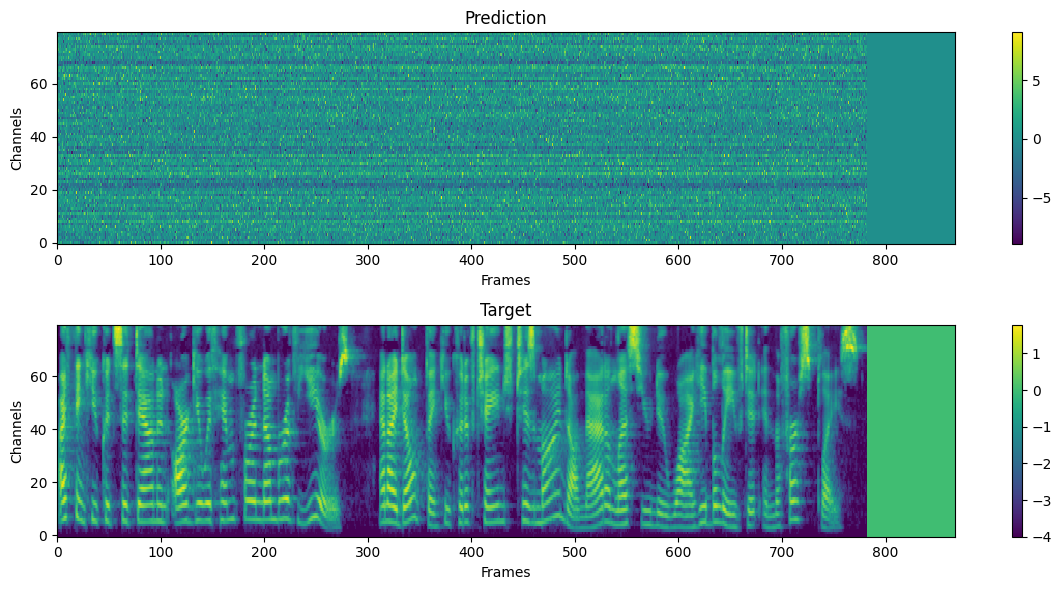

  0%|          | 1/818 [00:03<51:03,  3.75s/it, epoch=1, loss=16.8]/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
 12%|█▏        | 100/818 [02:27<16:03,  1.34s/it, epoch=1, loss=1.65]

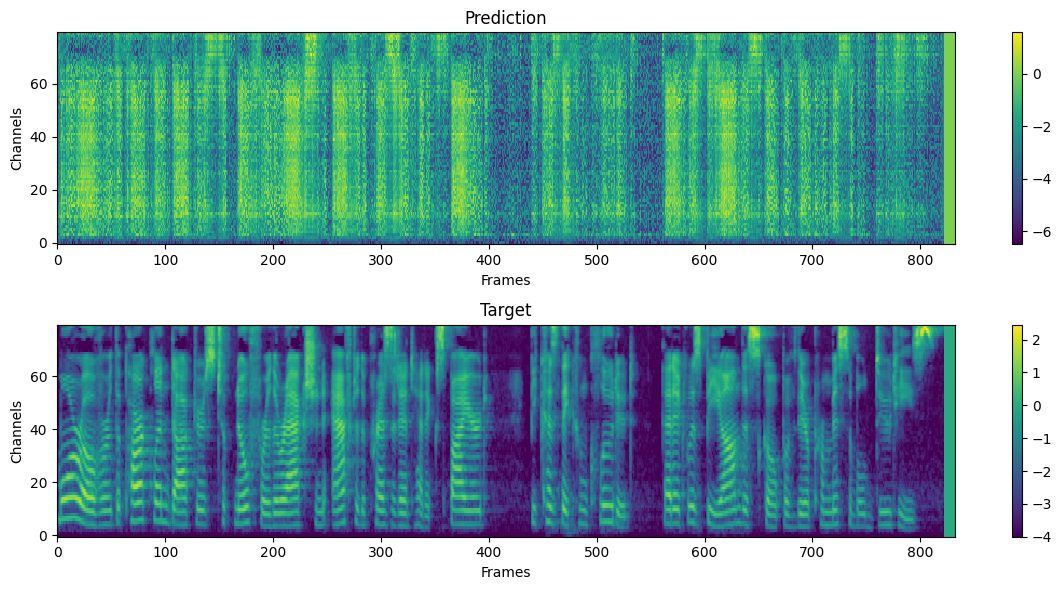

 24%|██▍       | 200/818 [04:53<16:17,  1.58s/it, epoch=1, loss=0.991]

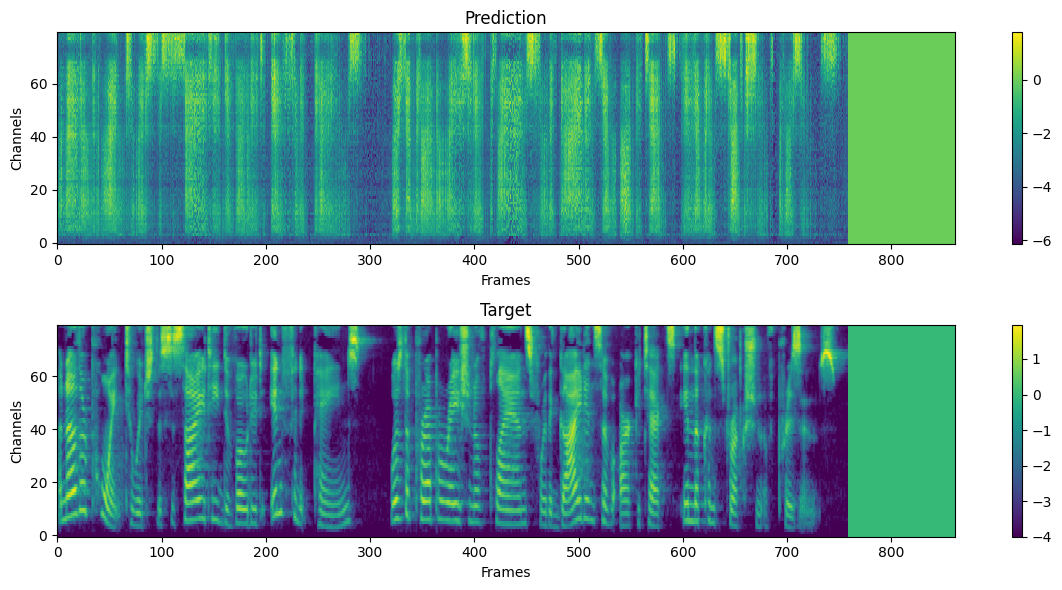

 37%|███▋      | 300/818 [07:17<11:54,  1.38s/it, epoch=1, loss=0.845]

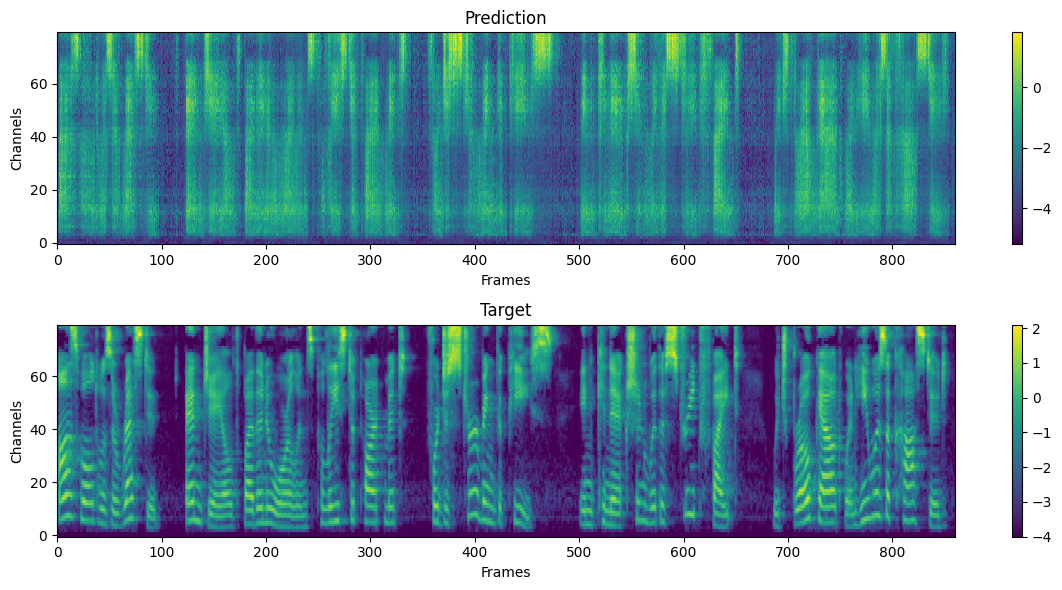

 49%|████▉     | 400/818 [09:37<09:31,  1.37s/it, epoch=1, loss=0.826]

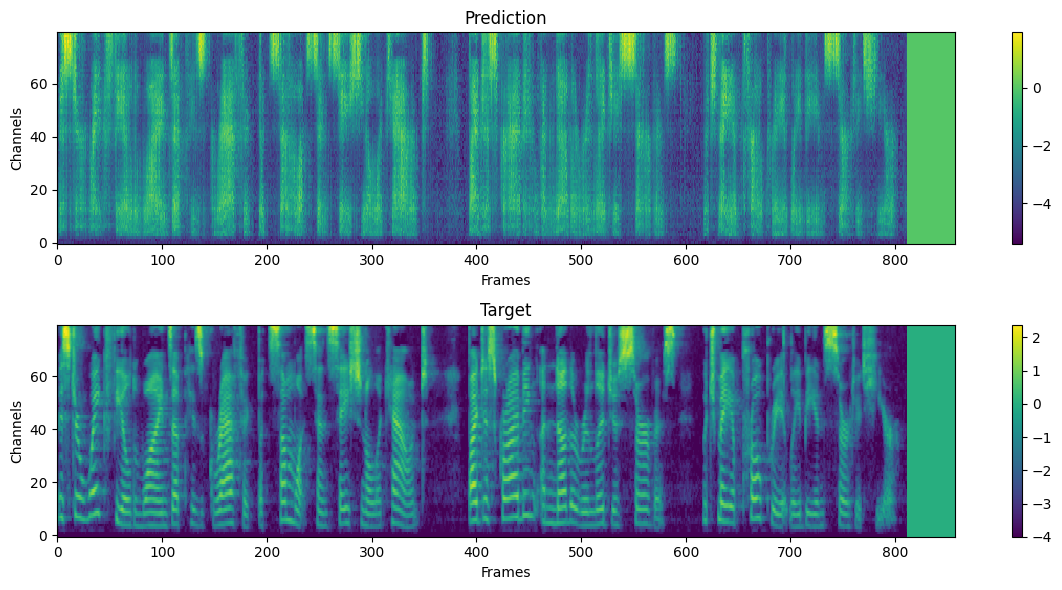

 61%|██████    | 500/818 [12:00<07:29,  1.41s/it, epoch=1, loss=0.608]

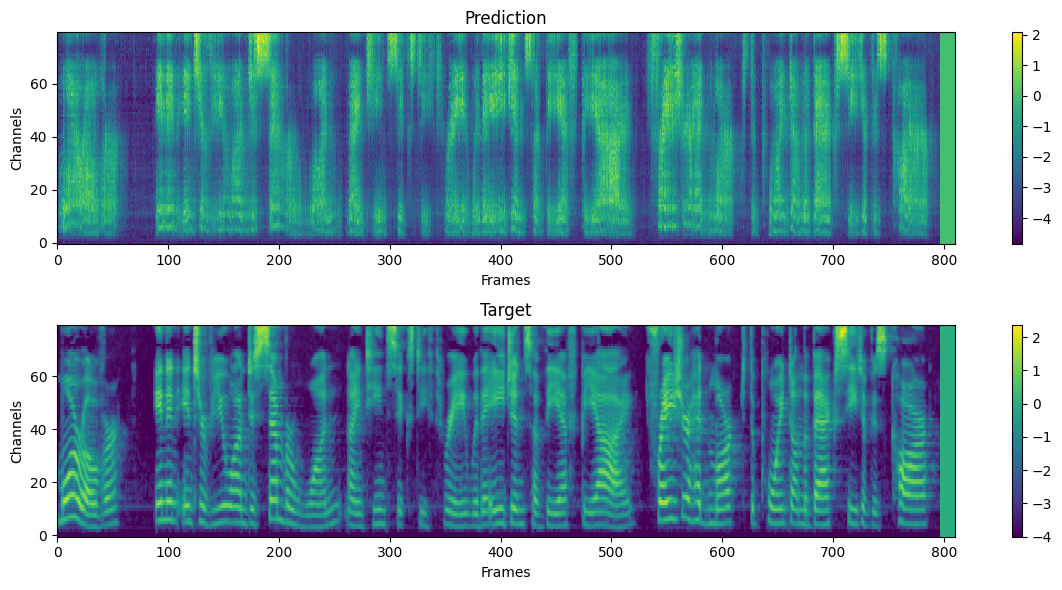

 73%|███████▎  | 600/818 [14:22<05:17,  1.45s/it, epoch=1, loss=0.572]

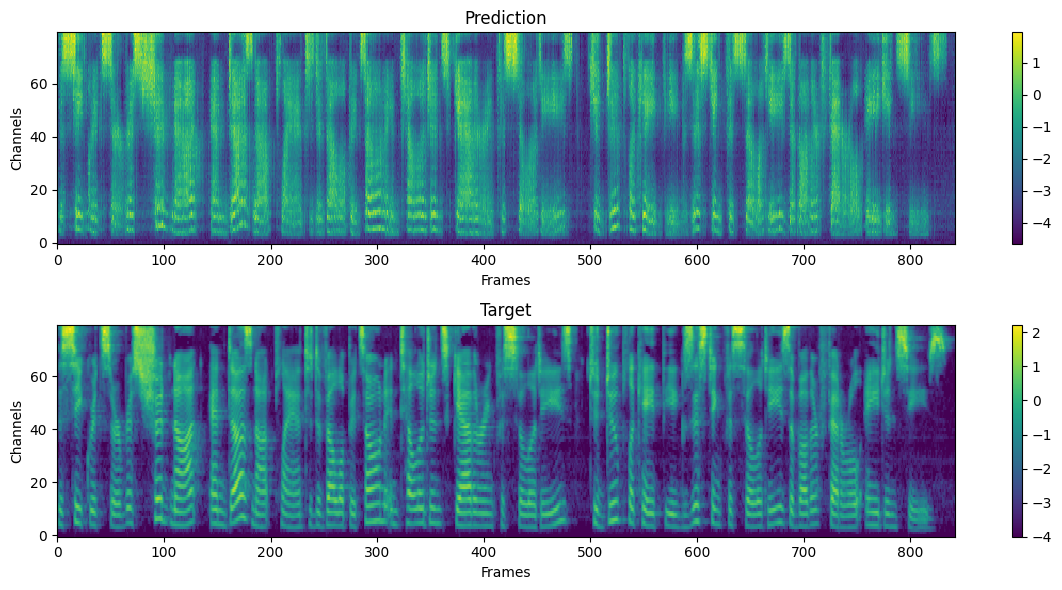

 86%|████████▌ | 700/818 [16:43<02:43,  1.38s/it, epoch=1, loss=0.512]

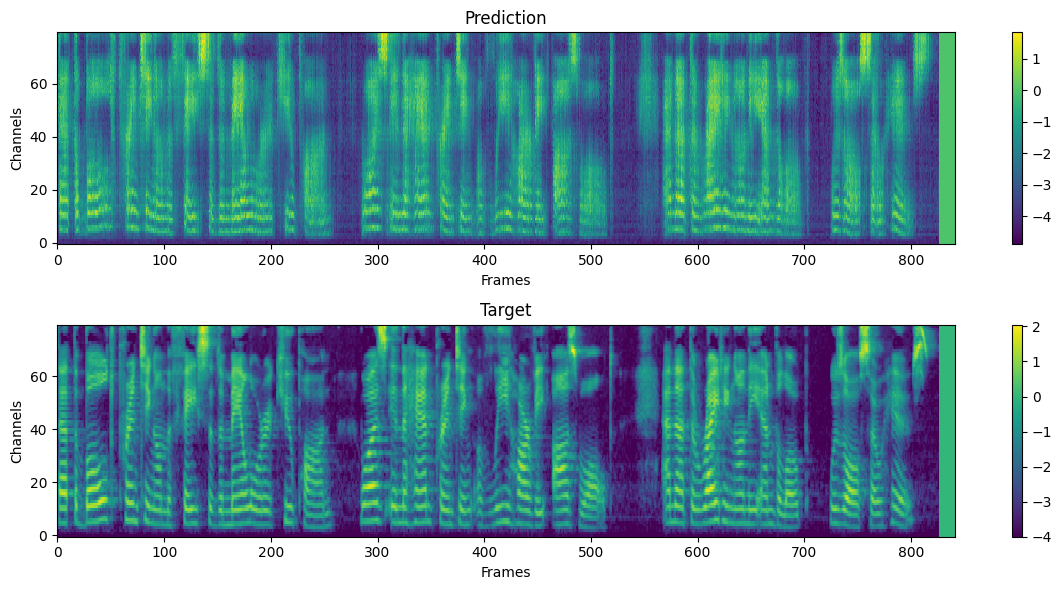

 98%|█████████▊| 800/818 [19:05<00:25,  1.40s/it, epoch=1, loss=0.535]

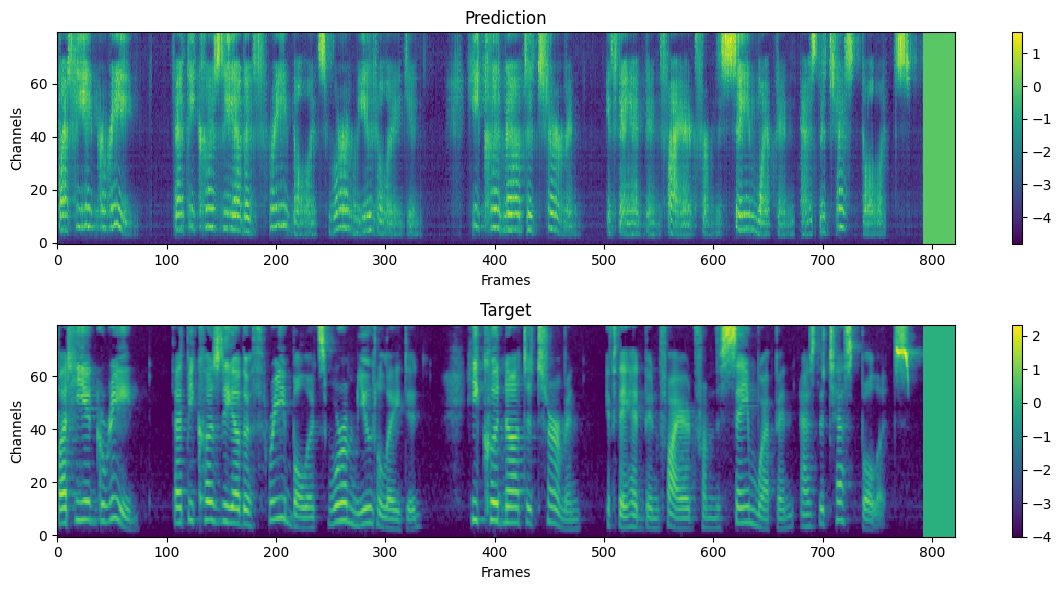

100%|██████████| 818/818 [19:30<00:00,  1.43s/it, epoch=1, loss=0.484]


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transformer_tts_dataset = TextMelLoader("./data/metadata.csv", config)
collate_fn = TextMelCollate()
dataloader = DataLoader(transformer_tts_dataset, batch_size=16, shuffle=True, drop_last=True, collate_fn=collate_fn)

config = Config()
model = TransformerTTS(config).to(device)
criterion = TransformerTTSLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# print(len(dataloader))
epoch = 1
# 데이터로더에서 데이터를 가져와서 확인하기
for epoch in range(epoch):
    tqdm_bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for i, data in tqdm_bar:

        phoneme, phoneme_len, mel, stop, mel_len = data
        phoneme = phoneme.to(device)
        mel = mel.to(device)
        stop = stop.to(device)
        phoneme_len = phoneme_len.to(device)
        mel_len = mel_len.to(device)

        post_mel_pred, mel_pred, stop_pred = model(phoneme, phoneme_len, mel, mel_len)

        loss = criterion(post_mel_pred, mel_pred, stop_pred, mel, stop)
        tqdm_bar.set_postfix(epoch=epoch+1, loss=loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            pred = post_mel_pred[0].detach().cpu().numpy().transpose(1, 0)
            targ = mel[0].detach().cpu().numpy().transpose(1, 0)
            visualize_spectrogram(pred, targ)